# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing GHG-emission data 
- Log-transforming GHG data
- Combining GHG data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (GHG) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population, countrysize)
- Fitting simple mixed effects models with each predictor seperately (time, population, countrysize, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

# Cleaning and combining data 

In [14]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

df.info

df.describe

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

In [15]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [16]:
melted_df.describe()

,iso,Country/Region,unit,Year,ghg
count,5983,5983,5983,5983,5983.00
unique,193,193,1,31,4569.00
top,CHN,China,MtCO2e,1990,0.02
freq,31,31,5983,193,29.00


In [17]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso             5983 non-null   object
 1   Country/Region  5983 non-null   object
 2   unit            5983 non-null   object
 3   Year            5983 non-null   object
 4   ghg             5983 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [20]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [21]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


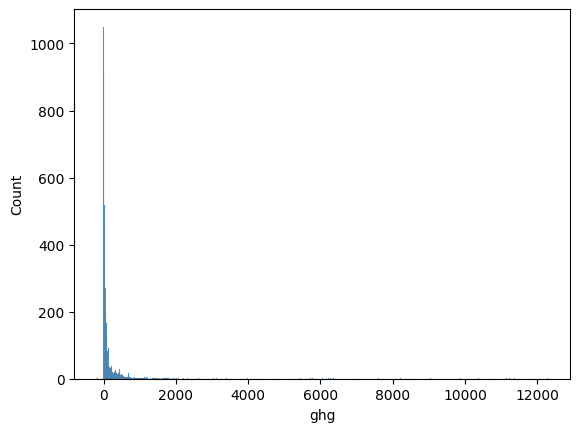

In [26]:
sns.histplot(data=melted_df, x='ghg', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [27]:
# Adding a small value to each value in 'ghg' column to avoid logarithm of zero
melted_df['log_ghg'] = np.log(melted_df['ghg'] + 1e-20)

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


C:\Users\marc1\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


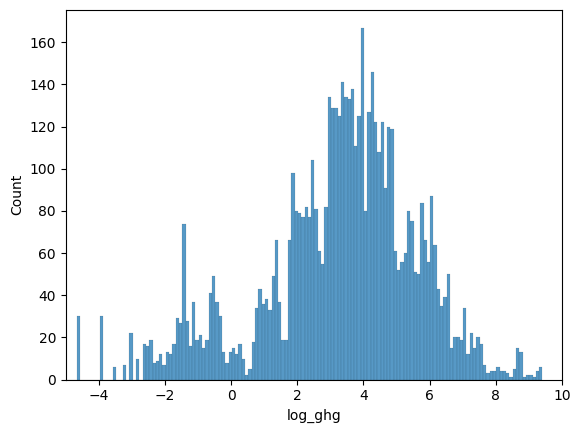

In [28]:
sns.histplot(data=melted_df, x='log_ghg', binwidth=0.1)
# Setting x-axis limit
plt.xlim(left=-5)
plt.xlim(right=10)
plt.show()

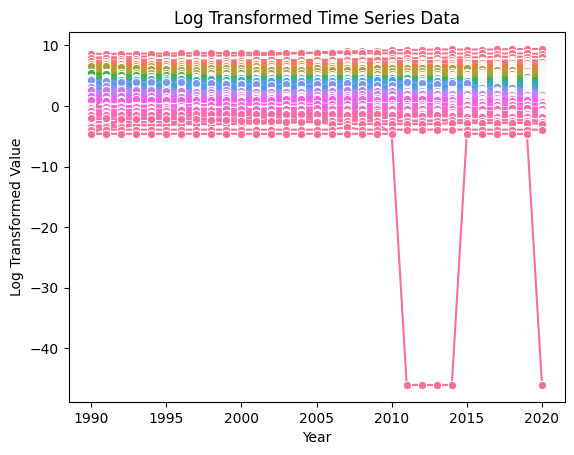

In [29]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

### Add predictors to our GHG-dataset

In [13]:
#Read predictor file 

pred = pd.read_excel('git_data\predictor_data.xlsx')

display(pred)

,Country Name,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,Aruba,ABW,1960,54608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,130692579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1960,8622466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1960,97256290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,1960,5357195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17769,Swaziland,SWZ,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569174
17770,"Tanzania, United Republic of",TZA,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.751511
17771,Turkey,TUR,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352290
17772,"Venezuela, Bolivarian Republic o",VEN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.478761


In [30]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

print(melted_df)
display(melted_df)

     Country Code Country/Region    unit    Year      ghg    log_ghg
0             CHN          China  MtCO2e  1990.0  2892.41   7.969845
1             USA  United States  MtCO2e  1990.0  5448.74   8.603140
2             IND          India  MtCO2e  1990.0  1020.11   6.927666
3             RUS         Russia  MtCO2e  1990.0  2624.74   7.872737
4             IDN      Indonesia  MtCO2e  1990.0  1140.84   7.039520
...           ...            ...     ...     ...      ...        ...
5978          COK   Cook Islands  MtCO2e  2020.0     0.07  -2.659260
5979          NRU          Nauru  MtCO2e  2020.0     0.05  -2.995732
5980          TUV         Tuvalu  MtCO2e  2020.0     0.02  -3.912023
5981          NIU           Niue  MtCO2e  2020.0     0.00 -46.051702
5982          FJI           Fiji  MtCO2e  2020.0    -0.81        NaN

[5983 rows x 6 columns]


,Country Code,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023
5981,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702


In [31]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')
ghg_full = ghg_full.drop(columns=['Country Name'])

print(ghg_full)
display(ghg_full)

     Country Code Country/Region    unit    Year      ghg    log_ghg  \
0             CHN          China  MtCO2e  1990.0  2892.41   7.969845   
1             USA  United States  MtCO2e  1990.0  5448.74   8.603140   
2             IND          India  MtCO2e  1990.0  1020.11   6.927666   
3             RUS         Russia  MtCO2e  1990.0  2624.74   7.872737   
4             IDN      Indonesia  MtCO2e  1990.0  1140.84   7.039520   
...           ...            ...     ...     ...      ...        ...   
6746          COK   Cook Islands  MtCO2e  2020.0     0.07  -2.659260   
6747          NRU          Nauru  MtCO2e  2020.0     0.05  -2.995732   
6748          TUV         Tuvalu  MtCO2e  2020.0     0.02  -3.912023   
6749          NIU           Niue  MtCO2e  2020.0     0.00 -46.051702   
6750          FJI           Fiji  MtCO2e  2020.0    -0.81        NaN   

      Population, total  Land area (sq. km)    WGI VA    WGI PS    WGI GE  \
0          1.135185e+09           9388250.0       NaN     

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662
6748,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN,0.605705
6749,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6751 entries, 0 to 6750
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6751 non-null   object 
 1   Country/Region      6751 non-null   object 
 2   unit                6751 non-null   object 
 3   Year                6751 non-null   float64
 4   ghg                 6750 non-null   float64
 5   log_ghg             6662 non-null   float64
 6   Population, total   5921 non-null   float64
 7   Land area (sq. km)  5797 non-null   float64
 8   WGI VA              4117 non-null   float64
 9   WGI PS              4073 non-null   float64
 10  WGI GE              4038 non-null   float64
 11  WGI RQ              4041 non-null   float64
 12  WGI RL              4114 non-null   float64
 13  WGI CC              4057 non-null   float64
 14  Education           3635 non-null   float64
 15  Innovation          2994 non-null   float64
 16  Social

### Save combined data

In [39]:
ghg_full.to_csv('git_data\GHG-modelling.csv', index=False)

# Modelling GHG data 


### Assessing data 

Our full GHG-dataset does contain a significant amount of Na's. Since the linear regression dont handle Na's well, we have decided to drop countries that contains Na's. This leave us with 102 countries for GHG analysis. 

In [4]:
ghg_full = pd.read_csv('git_data\GHG-modelling.csv')
display(ghg_full)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662
6748,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN,0.605705
6749,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
ghg_full_filtered = ghg_full[(ghg_full['Year'] >= 1996) & (ghg_full['Year'] <= 2020)]

# Identify countries with NaN in 'log_ghg' for years other than 1997 and 1999
countries_with_nan = ghg_full_filtered[
    (ghg_full_filtered['Year'] != 1997) & 
    (ghg_full_filtered['Year'] != 1999) & 
    (ghg_full_filtered['log_ghg'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_nan)]

# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Country Name', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = ghg_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

# Remove rows with 'Country Code' equal to 'NIU'
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered['Country Code'] != 'NIU']

# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = ghg_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

display(countries_with_nan)
# Display the filtered dataset
display(ghg_full_filtered)

Countries removed using country code: ['KNA', 'YEM', 'MKD', 'KGZ', 'TZA', 'LBY', 'STP', 'SVK', 'COK', 'EGY', 'VEN', 'VNM', 'LCA', 'LIE', 'MDA', 'SWZ', 'VCT', 'BOL', 'GMB', 'SSD', 'BHS', 'PRK', 'TUR', 'COG', 'CIV', 'KOR', 'CZE', 'FSM', 'IRN', 'LAO']


array(['GEO', 'CPV', 'BTN', 'FJI', 'MNE', 'ROU', 'SLB'], dtype=object)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
1172,CHN,China,MtCO2e,1996.0,3982.98,8.289786,1.217550e+09,9388230.0,-1.361545,-0.097849,-0.348654,-0.266653,-0.545590,-0.271190,5.295780,11628.0,7.4,NaN,0.512847
1173,USA,United States,MtCO2e,1996.0,5933.25,8.688327,2.693940e+08,9158960.0,1.348661,0.935006,1.524920,1.593102,1.500219,1.571041,78.833359,106892.0,5.5,NaN,0.217347
1174,IND,India,MtCO2e,1996.0,1293.39,7.165022,9.832812e+08,2973190.0,0.476564,-0.972584,-0.111607,-0.553350,0.313456,-0.381090,6.163050,1661.0,NaN,NaN,0.721646
1175,RUS,Russia,MtCO2e,1996.0,1858.96,7.527772,1.481601e+08,16377960.0,-0.219652,-1.177854,-0.452227,-0.430167,-0.794188,-1.053342,43.852211,18014.0,NaN,NaN,0.356202
1176,IDN,Indonesia,MtCO2e,1996.0,1101.48,7.004410,2.013738e+08,1811570.0,-0.923690,-1.131379,-0.705336,-0.050810,-0.489870,-0.864106,11.616530,40.0,8.1,NaN,0.479031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6740,PLW,Palau,MtCO2e,2020.0,0.20,-1.609438,1.797200e+04,460.0,1.078570,1.166012,0.386292,0.547489,0.685481,0.599187,NaN,NaN,NaN,NaN,0.367040
6741,MHL,Marshall Islands,MtCO2e,2020.0,0.16,-1.832581,4.341300e+04,180.0,1.130496,0.983442,0.117473,-0.670987,0.595379,0.467346,NaN,NaN,NaN,NaN,0.653810
6745,KIR,Kiribati,MtCO2e,2020.0,0.09,-2.407946,1.264630e+05,810.0,1.115723,1.163733,0.135920,-0.430563,1.009464,0.467346,NaN,NaN,NaN,14.464986,0.595013
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662


In [49]:
print(len(ghg_full_filtered['Country Code'].unique()))
print(ghg_full_filtered.isna().sum())


152
Country Code             0
Country/Region           0
unit                     0
Year                     0
ghg                      0
log_ghg                  0
Population, total        0
Land area (sq. km)      11
WGI VA                   0
WGI PS                  24
WGI GE                  43
WGI RQ                  43
WGI RL                   0
WGI CC                  38
Education             1141
Innovation            1459
Social Inequality     2045
ICT                    767
Health                   0
dtype: int64


In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = ghg_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Education', 'Innovation', 'Social Inequality']

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
ghg_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(ghg_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [53]:
# Verify the imputed data
print(ghg_full_imputed.isna().sum())

Country Code             0
Country/Region           0
unit                     0
Year                     0
ghg                      0
log_ghg                  0
Education             1141
Innovation            1459
Social Inequality     2045
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64


In [57]:
ghg = ghg_full_imputed.drop(columns=['unit', 'Education', 'Innovation', 'Social Inequality'])
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [58]:
len(ghg['Country Code'].unique())

152

In [89]:
ghg.to_csv('git_data\GHG-modelling.csv', index=False)

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

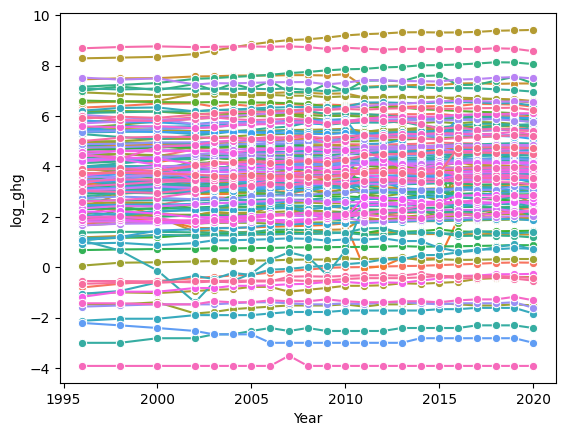

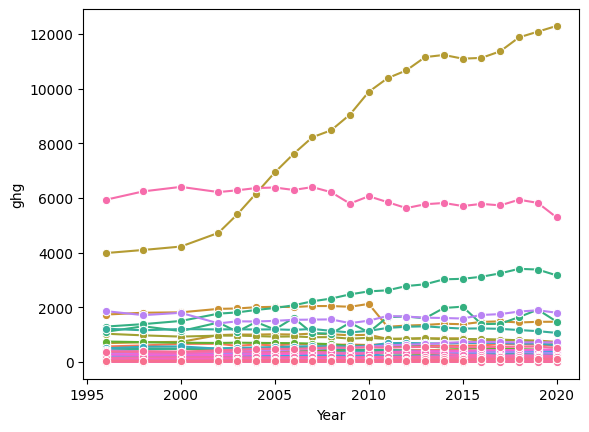

In [68]:
plt1 = sns.lineplot(data=ghg, x='Year', y='log_ghg', hue='Country Code', marker='o', legend=False)
plt.show()

plt2 = sns.lineplot(data=ghg, x='Year', y='ghg', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

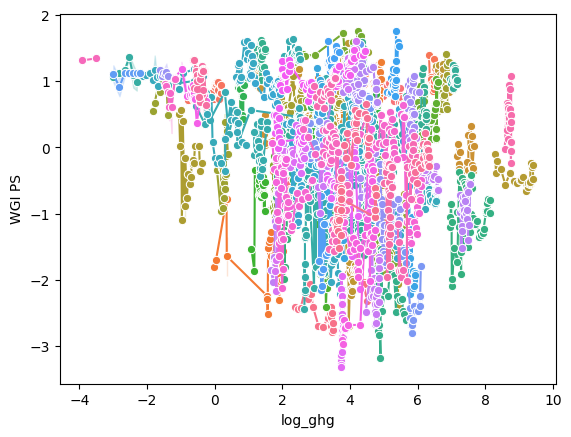

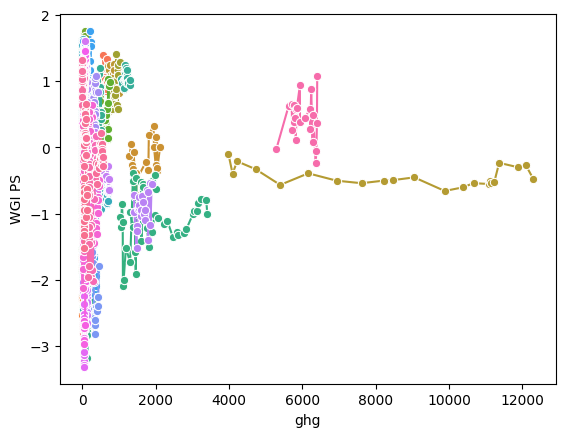

In [69]:
sns.lineplot(data=ghg, x='log_ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

sns.lineplot(data=ghg, x='ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Show the plot
plt.show()

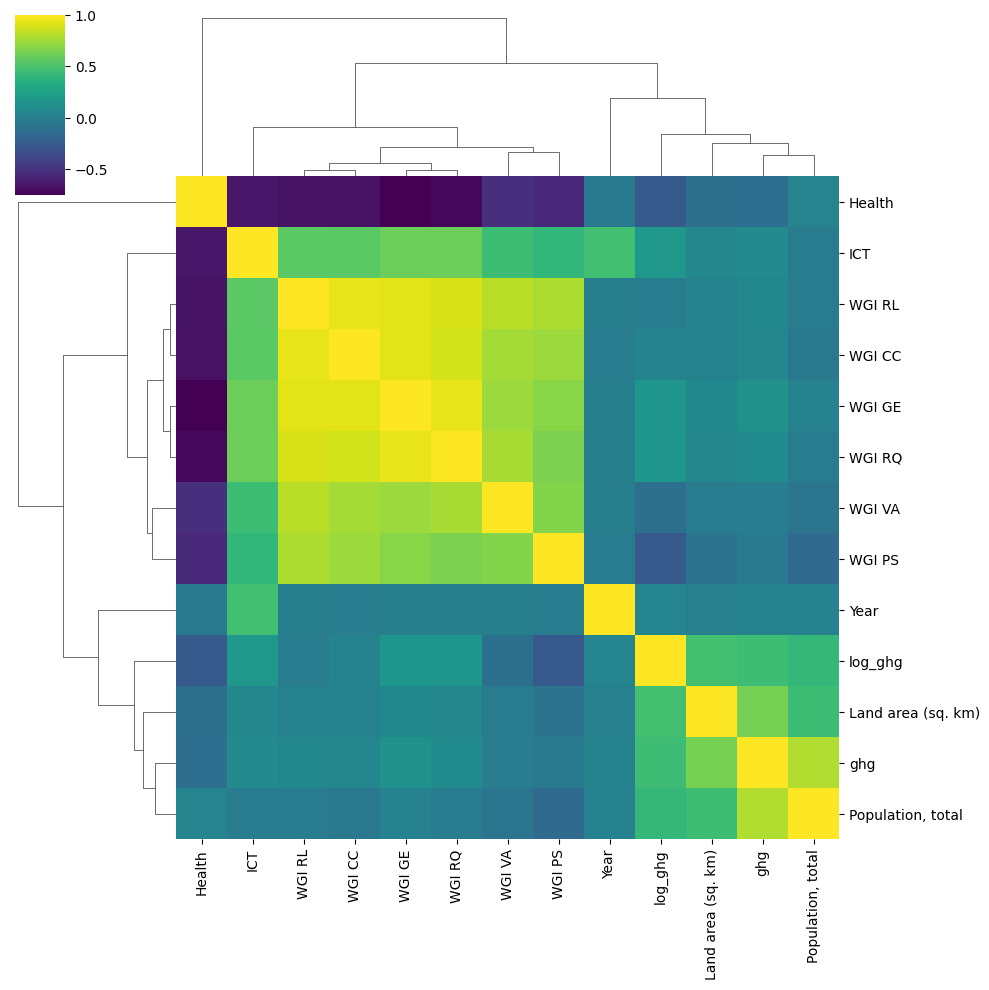

In [70]:
ghg_num = ghg[ghg.select_dtypes(exclude=['object']).columns]

sns.clustermap(ghg_num.corr(), cmap='viridis')
plt.show()

## Splitting the data set

Our Y variable must be lagged 5 years

for y delay at row i take year i-5 and put y delay 

In [ ]:
for index, row in ghg.iterrows():
    

In [76]:
lag_years = 5

# Group the DataFrame by country
grouped = ghg.groupby('Country Code')

# Lag the target variable within each group
ghg['y_lagged'] = grouped['log_ghg'].shift(-4)

In [78]:
print(ghg[(ghg['Country Code'] == 'CHN') & (ghg['Year'] == 2000.0)])

     Country Code Country/Region    unit    Year      ghg   log_ghg  \
1928          CHN          China  MtCO2e  2000.0  4221.71  8.347996   

     Country Name  Population, total  Land area (sq. km)    WGI VA    WGI PS  \
1928        China       1.262645e+09           9388220.0 -1.384081 -0.209917   

        WGI GE    WGI RQ    WGI RL    WGI CC  Education  y_lagged  
1928 -0.158843 -0.324955 -0.516117 -0.208549     7.5585  8.844202  


In [73]:
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [75]:
from sklearn.model_selection import GroupShuffleSplit

In [82]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['log_ghg', 'Country/Region', 'ghg']) 
y = ghg['log_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]



In [83]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2332, 12) (2332,)
Validation set shape: (506, 12) (506,)
Test set shape: (506, 12) (506,)


In [84]:
performances = []

## Baseline model 

In [85]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import pickle as pkl

In [152]:
model_name = 'dummy'

for y, nsplit in zip([y_train, y_val, y_test], ['train', 'val', 'test']):
    # Get indices where 'NaN' values are present in the 'log_ghg' column
    nan_indices = np.where(y.isnull())[0].tolist()
    # Ignore rows with NaN values
    y_filtered = y.dropna()
    # Calculate mean value of the target variable
    mean_value = y_filtered.mean()
    
    performance = np.sqrt(mean_squared_error(y_filtered, [mean_value]*len(y_filtered)))
    r2 = r2_score(y_filtered, [mean_value]*len(y_filtered))
    performances.append({
        'model': model_name,
        'split': nsplit,
        'rmse': performance.round(4),
        'r2': r2.round(4)
    })

## Mixed Effects Linear Regressor

In [ ]:
model_name = Government Readiness MELF

#Now let's fit a linear model with only theoretical predictors

gov_preds = [3, 6, 7, 10, 11, 12]

reg = LinearRegression().fit(X_train[:,gov_preds], y_train)
pkl.dump(reg, file=open(f'ghg_MELF.pkl', 'wb')) # save the model
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,gov_preds])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-demographics',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [157]:
countries = ghg_full['Country Code']

0       CHN
1       USA
2       IND
3       RUS
4       IDN
       ... 
6114    COK
6115    NRU
6116    TUV
6117    NIU
6118    FJI
Name: Country Code, Length: 6119, dtype: object

In [163]:
display(X_train)

,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT
3438,HND,2007.0,7924462.0,111890.00,-0.192797,-0.437030,-0.553879,-0.282702,-0.928943,-0.791543,NaN,NaN,2.8,NaN
1763,FRA,1999.0,60504420.0,547566.00,NaN,NaN,NaN,NaN,NaN,NaN,53.005081,13592.0,7.7,31.633476
5564,NLD,2018.0,17231624.0,33670.00,1.499295,0.838097,1.809711,2.013644,1.744731,1.888952,83.652473,2111.0,8.9,66.363177
3515,NRU,2007.0,10267.0,20.00,1.056957,1.088966,-0.584644,-0.697122,0.502609,-0.356638,NaN,NaN,NaN,NaN
5108,DMA,2015.0,70007.0,750.00,0.878904,1.054432,0.213033,0.240543,0.701885,0.606967,NaN,NaN,NaN,53.803960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,CHE,1991.0,6799978.0,39529.35,NaN,NaN,NaN,NaN,NaN,NaN,27.169800,2949.0,NaN,NaN
4595,IRL,2013.0,4623816.0,68890.00,1.311735,0.901076,1.504589,1.574062,1.709155,1.646098,NaN,NaN,7.3,58.871023
963,CAN,1995.0,29302311.0,8965590.00,NaN,NaN,NaN,NaN,NaN,NaN,90.464058,2431.0,7.3,NaN
4426,GTM,2012.0,14781942.0,107160.00,-0.356139,-0.633820,-0.787667,-0.263001,-1.083920,-0.678763,16.934290,7.0,NaN,50.261684


In [165]:
# Assuming you have a list of countries
country_codes = ghg_full['Country Code']

gov_preds = [3, 6, 7, 10, 11, 12]
country_performances = []



for country in country_codes:
    # Filter data for the current country
    X_train_country = X_train[X_train['Country Code'] == country]
    X_val_country = X_val[X_val['Country Code'] == country]
    X_test_country = X_test[X_test['Country Code'] == country]
    y_train_country = y_train[X_train['Country Code'] == country]
    y_val_country = y_val[X_val['Country Code'] == country]
    y_test_country = y_test[X_test['Country Code'] == country]
    
    # Filter columns by indices
    X_train_country_filtered = X_train_country.iloc[:, gov_preds]
    X_val_country_filtered = X_val_country.iloc[:, gov_preds]
    X_test_country_filtered = X_test_country.iloc[:, gov_preds]
    
    # Train linear regression model
    reg = LinearRegression().fit(X_train_country_filtered, y_train_country)
    
    # Save the model
    with open(f'{country}_gov_MELF.pkl', 'wb') as f:
        pkl.dump(reg, f)
    
    for X, y, split in zip([X_train_country, X_val_country, X_test_country],
                           [y_train_country, y_val_country, y_test_country],
                           ['train', 'val', 'test']):
        preds = reg.predict(X[:, gov_preds])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'linear-{country}',
                             'split': split,
                             'rmse': performance.round(4),
                             'r2': r2.round(4)})


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## MERF Model

In [133]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

### Combined MERF Model

In [175]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -8825.249689251526 at iteration 1.
INFO     [merf.py:307] Training GLL is -12808.266967406207 at iteration 2.
INFO     [merf.py:307] Training GLL is -13091.005547200893 at iteration 3.
INFO     [merf.py:307] Training GLL is -13119.945832467369 at iteration 4.
INFO     [merf.py:307] Training GLL is -13004.59227503651 at iteration 5.
INFO     [merf.py:307] Training GLL is -13041.337580881787 at iteration 6.
INFO     [merf.py:307] Training GLL is -13230.100301656574 at iteration 7.
INFO     [merf.py:307] Training GLL is -12957.535920114291 at iteration 8.
INFO     [merf.py:307] Training GLL is -12985.020397750197 at iteration 9.
INFO     [merf.py:307] Training GLL is -13095.43135878616 at iteration 10.
INFO     [merf.py:307] Training GLL is -13152.337545087366 at iteration 11.
INFO     [merf.py:307] Training GLL is -13133.32685829354 at iteration 12.
INFO     [merf.py:307] Training GLL is -13071.736941730813 at iteration 13.
INFO     [merf.py:307] Tr

In [176]:
print(performances)

[{'model': 'X_train', 'split': 'train', 'rmse': 0.0548, 'mae': 0.0275, 'mape': 4296360502.0512, 'r2': 0.9994}, {'model': 'X_val', 'split': 'val', 'rmse': 1.1217, 'mae': 0.7752, 'mape': 0.5636, 'r2': 0.6901}, {'model': 'X_test', 'split': 'test', 'rmse': 0.9631, 'mae': 0.7821, 'mape': 0.8003, 'r2': 0.77}]


In [177]:
perf_df = pd.DataFrame(performances)

In [179]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0548
MAE:  0.0275
MAPE:  4296360502.0512
R2:  0.9994


Model:  X_val
Split:  val
RMSE:  1.1217
MAE:  0.7752
MAPE:  0.5636
R2:  0.6901


Model:  X_test
Split:  test
RMSE:  0.9631
MAE:  0.7821
MAPE:  0.8003
R2:  0.77




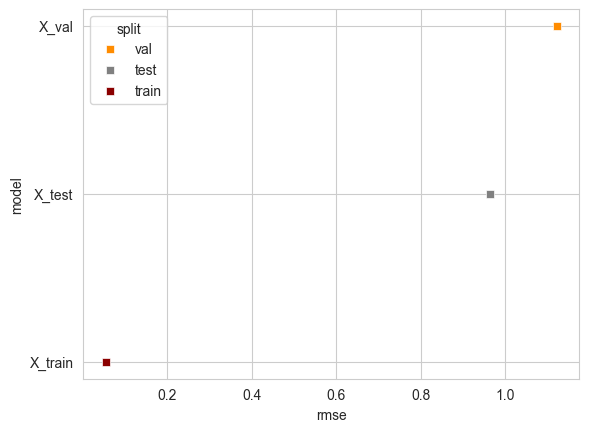

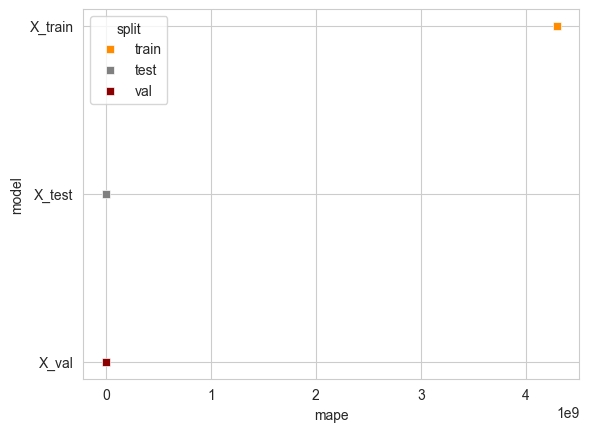

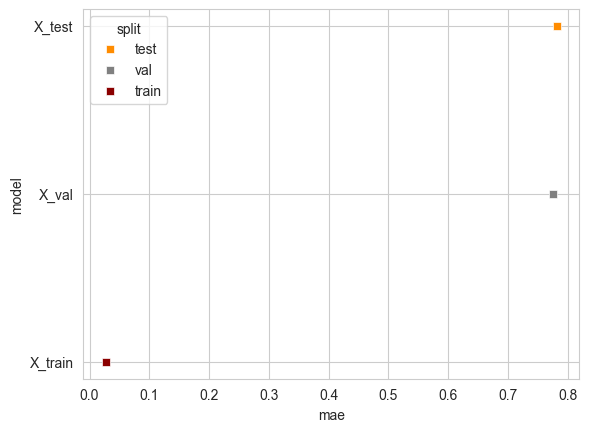

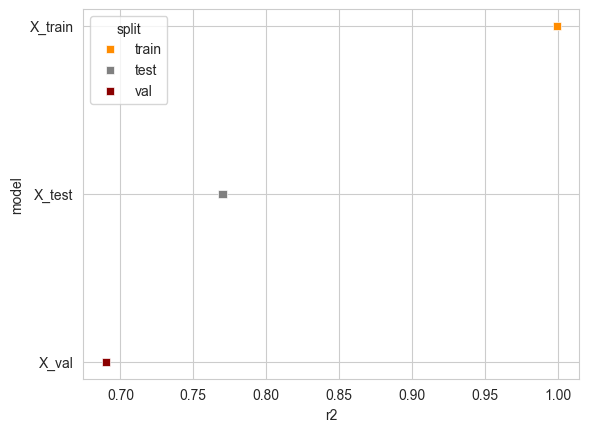

In [178]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

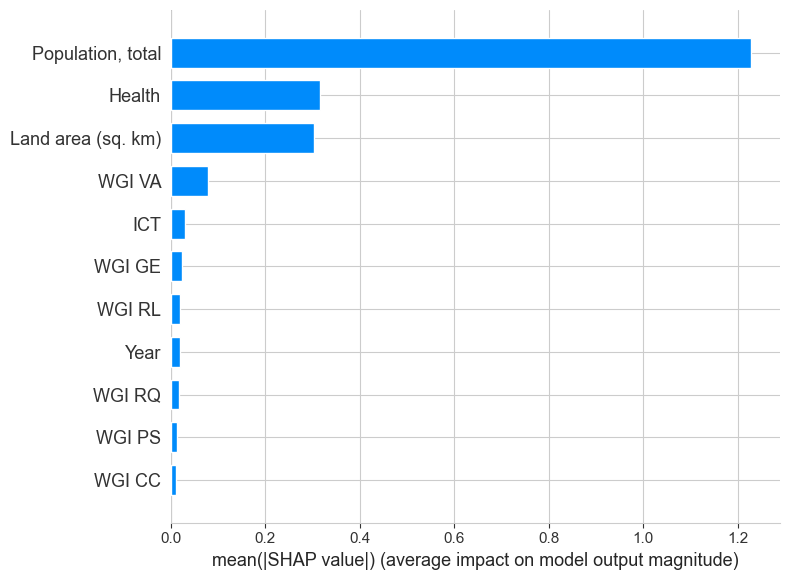

In [142]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [166]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI VA', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI VA', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -8732.208616362916 at iteration 1.
INFO     [merf.py:307] Training GLL is -12331.20009535656 at iteration 2.
INFO     [merf.py:307] Training GLL is -12425.473189947952 at iteration 3.
INFO     [merf.py:307] Training GLL is -12414.23358198506 at iteration 4.
INFO     [merf.py:307] Training GLL is -12457.606208737074 at iteration 5.
INFO     [merf.py:307] Training GLL is -12335.199736399054 at iteration 6.
INFO     [merf.py:307] Training GLL is -12441.75985810842 at iteration 7.
INFO     [merf.py:307] Training GLL is -12543.24058591835 at iteration 8.
INFO     [merf.py:307] Training GLL is -12547.386215610773 at iteration 9.
INFO     [merf.py:307] Training GLL is -12604.105550435741 at iteration 10.
INFO     [merf.py:307] Training GLL is -12658.103058714336 at iteration 11.
INFO     [merf.py:307] Training GLL is -12556.13168584566 at iteration 12.
INFO     [merf.py:307] Training GLL is -12660.757857072993 at iteration 13.
INFO     [merf.py:307] Trai

In [168]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0571
MAE:  0.0303
MAPE:  2634978265.1492
R2:  0.9993


Model:  X_val
Split:  val
RMSE:  1.1617
MAE:  0.8908
MAPE:  0.6555
R2:  0.6677


Model:  X_test
Split:  test
RMSE:  1.0167
MAE:  0.793
MAPE:  1.1615
R2:  0.7437




In [171]:
perf_df = pd.DataFrame(performances)

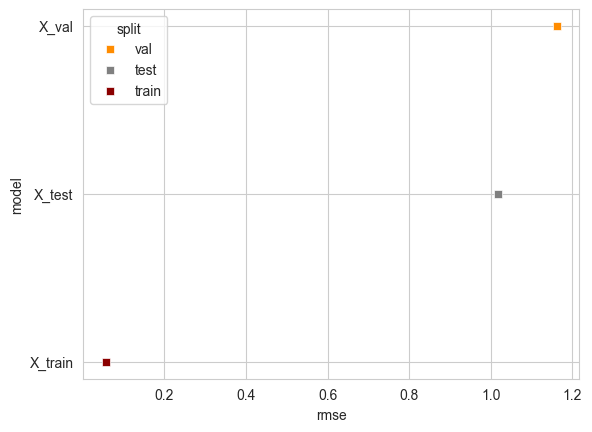

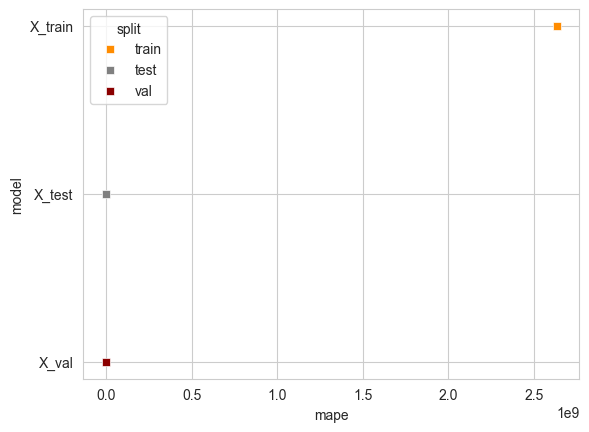

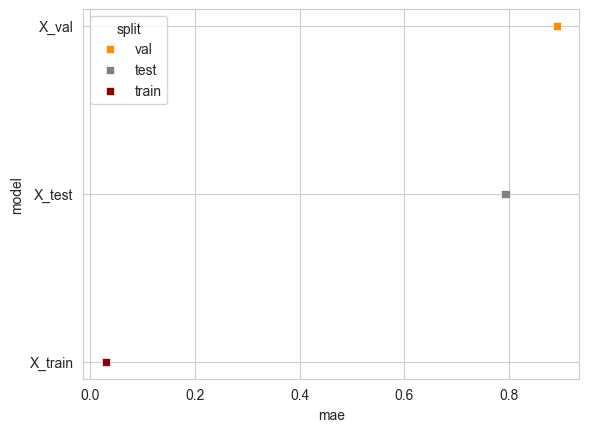

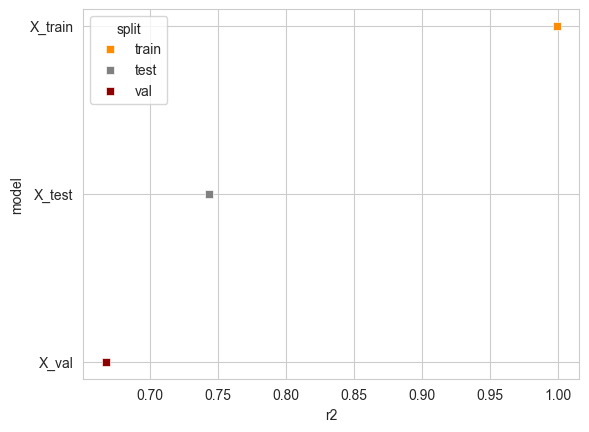

In [174]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

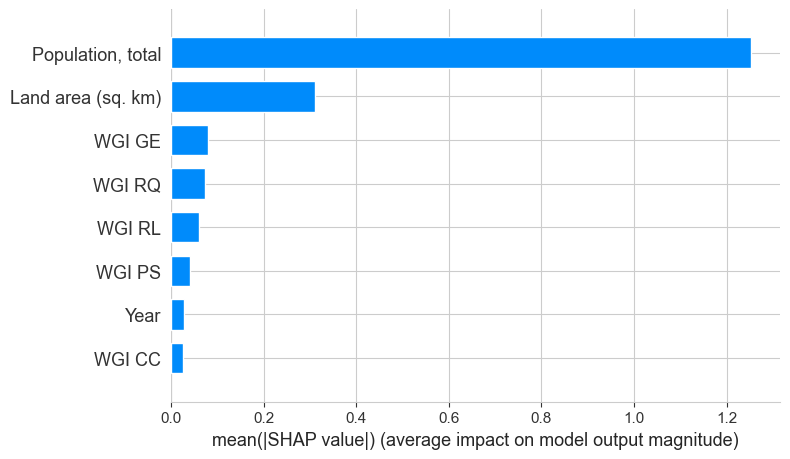

In [170]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [180]:
display(X_train)

,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,2016.0,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,2017.0,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,2018.0,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,2019.0,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [186]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Social Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -8874.01870363937 at iteration 1.
INFO     [merf.py:307] Training GLL is -13013.79848519828 at iteration 2.
INFO     [merf.py:307] Training GLL is -13455.437531918744 at iteration 3.
INFO     [merf.py:307] Training GLL is -13292.135543924283 at iteration 4.
INFO     [merf.py:307] Training GLL is -13313.827448557979 at iteration 5.
INFO     [merf.py:307] Training GLL is -13265.02466758524 at iteration 6.
INFO     [merf.py:307] Training GLL is -13312.176644116365 at iteration 7.
INFO     [merf.py:307] Training GLL is -13325.50666855131 at iteration 8.
INFO     [merf.py:307] Training GLL is -13404.334085145636 at iteration 9.
INFO     [merf.py:307] Training GLL is -13406.799577136917 at iteration 10.
INFO     [merf.py:307] Training GLL is -13379.069310117933 at iteration 11.
INFO     [merf.py:307] Training GLL is -13467.839863579457 at iteration 12.
INFO     [merf.py:307] Training GLL is -13448.817043552703 at iteration 13.
INFO     [merf.py:307] Tra

In [189]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0507
MAE:  0.0252
MAPE:  3979542765.8264
R2:  0.9995


Model:  X_val
Split:  val
RMSE:  1.1104
MAE:  0.7902
MAPE:  0.5913
R2:  0.6964


Model:  X_test
Split:  test
RMSE:  0.9016
MAE:  0.7444
MAPE:  0.9362
R2:  0.7984




In [190]:
perf_df = pd.DataFrame(performances)

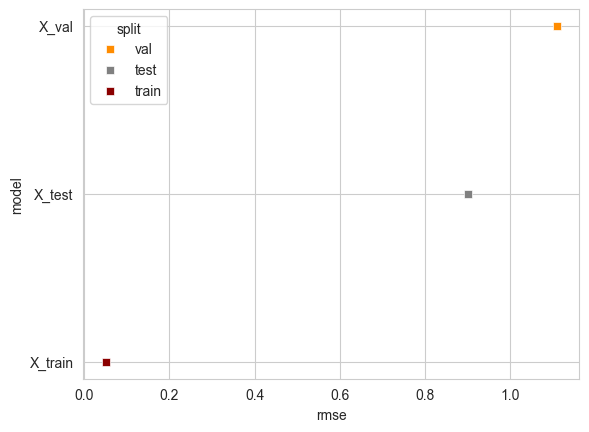

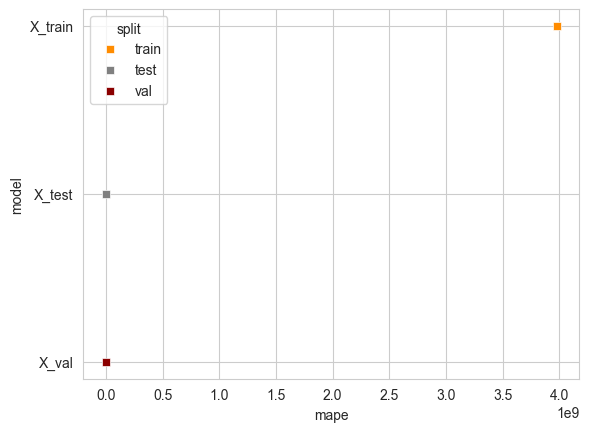

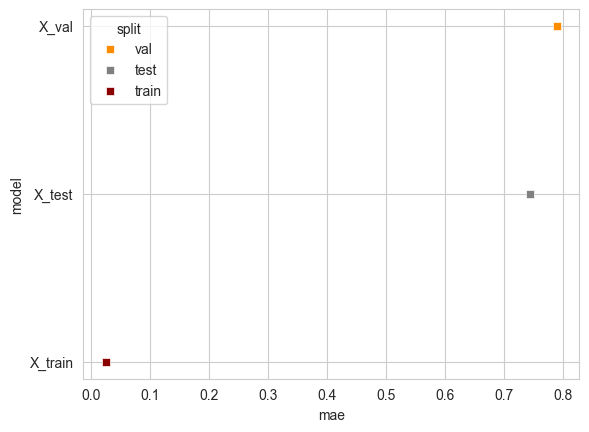

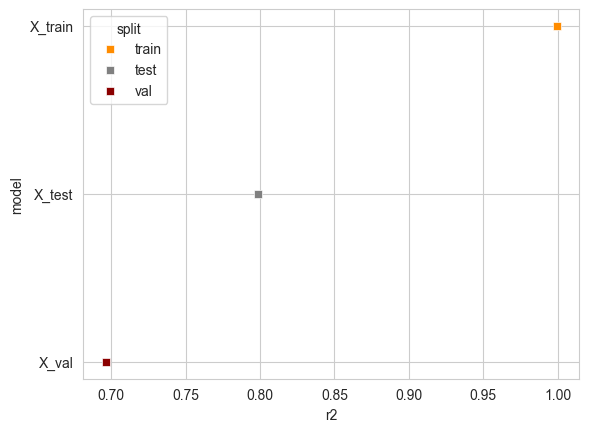

In [191]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

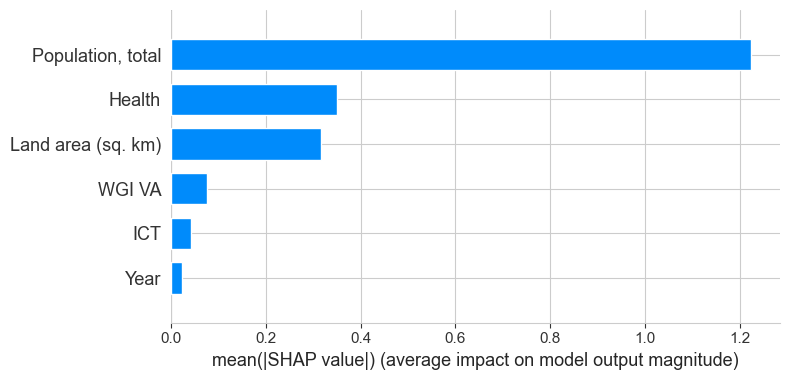

In [192]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")